In [ ]:
!pip install roboflow ultralytics torch torchvision torchaudio opencv-python pandas tqdm scikit-learn Pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/112.6 GB disk)


In [ ]:
from IPython.display import display, Image

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WZ3OZfiYUcvT8zsgwg4D")
project = rf.workspace("team-rahman").project("physics_lab_apparatus-kzk1d")
version = project.version(7)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to physics_lab_apparatus-7 in yolov11:: 100%|██████████| 14434/14434 [00:03<00:00, 3621.96it/s]


In [ ]:
import yaml, pandas as pd, os, json
from pathlib import Path
from tqdm import tqdm

yolo_root = Path(dataset.location)
out_dir = Path("mlcls_dataset")
out_dir.mkdir(exist_ok=True)

data_yaml_file = list(yolo_root.glob("**/data.yaml"))[0]
classes = yaml.safe_load(open(data_yaml_file))["names"]

with open(out_dir/"classes.txt", "w") as f:
    for c in classes:
        f.write(c+"\n")

def process_split(split):
    rows = []
    if not (yolo_root/split).exists():
        return
    img_dir = yolo_root/split/"images"
    lbl_dir = yolo_root/split/"labels"
    for img_path in tqdm(sorted(img_dir.glob("*.*"))):
        label_file = lbl_dir/f"{img_path.stem}.txt"
        present = set()
        if label_file.exists():
            for line in open(label_file):
                cid = int(line.split()[0])
                present.add(cid)
        rows.append({"filepath": str(img_path), "labels": " ".join(classes[c] for c in sorted(present))})
    pd.DataFrame(rows).to_csv(out_dir/f"{split}.csv", index=False)

for split in ["train", "valid", "val", "test"]:
    process_split(split)


100%|██████████| 302/302 [00:00<00:00, 10963.22it/s]


In [ ]:
import os, torch, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm

data_dir = Path("mlcls_dataset")
classes = [c.strip() for c in open(data_dir/"classes.txt")]
num_classes = len(classes)

train_df = pd.read_csv(data_dir/"train.csv")
valid_csv = data_dir/"valid.csv" if (data_dir/"valid.csv").exists() else data_dir/"val.csv"
val_df = pd.read_csv(valid_csv)

mlb = MultiLabelBinarizer(classes=classes)
train_labels = mlb.fit_transform(train_df["labels"].fillna("").str.split())
val_labels   = mlb.transform(val_df["labels"].fillna("").str.split())

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class MLSet(Dataset):
    def __init__(self, df, Y):
        self.df, self.Y = df, Y
    def __getitem__(self, i):
        x = Image.open(self.df["filepath"].iloc[i]).convert("RGB")
        return tfm(x), torch.tensor(self.Y[i]).float()
    def __len__(self): return len(self.df)

train_loader = DataLoader(MLSet(train_df,train_labels), batch_size=32, shuffle=True)
val_loader   = DataLoader(MLSet(val_df,val_labels), batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model = model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

best_val = 0
for epoch in range(1, 51):  # 50 epochs
    model.train()
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        opt.step()

    # validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            val_loss += criterion(model(x), y).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}/50  |  ValLoss: {val_loss:.4f}")

torch.save(model.state_dict(), "classifier_mobilenet.pt")
print("✅ Classifier Saved: classifier_mobilenet.pt")


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 80.1MB/s]


Epoch 1/50  |  ValLoss: 0.0927
Epoch 2/50  |  ValLoss: 0.0282
Epoch 3/50  |  ValLoss: 0.0575
Epoch 4/50  |  ValLoss: 0.0217
Epoch 5/50  |  ValLoss: 0.0250
Epoch 6/50  |  ValLoss: 0.0350
Epoch 7/50  |  ValLoss: 0.0307
Epoch 8/50  |  ValLoss: 0.0197
Epoch 9/50  |  ValLoss: 0.0335
Epoch 10/50  |  ValLoss: 0.0402
Epoch 11/50  |  ValLoss: 0.0232
Epoch 12/50  |  ValLoss: 0.0330
Epoch 13/50  |  ValLoss: 0.0241
Epoch 14/50  |  ValLoss: 0.0341
Epoch 15/50  |  ValLoss: 0.0255
Epoch 16/50  |  ValLoss: 0.0190
Epoch 17/50  |  ValLoss: 0.0198
Epoch 18/50  |  ValLoss: 0.0205
Epoch 19/50  |  ValLoss: 0.0188
Epoch 20/50  |  ValLoss: 0.0182
Epoch 21/50  |  ValLoss: 0.0569
Epoch 22/50  |  ValLoss: 0.5926
Epoch 23/50  |  ValLoss: 0.0185
Epoch 24/50  |  ValLoss: 0.0218
Epoch 25/50  |  ValLoss: 0.0195
Epoch 26/50  |  ValLoss: 0.0192
Epoch 27/50  |  ValLoss: 0.0218
Epoch 28/50  |  ValLoss: 0.0224
Epoch 29/50  |  ValLoss: 0.0221
Epoch 30/50  |  ValLoss: 0.0215
Epoch 31/50  |  ValLoss: 0.0218
Epoch 32/50  |  V

In [ ]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, average_precision_score
)
import numpy as np
from tqdm import tqdm

model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x = x.to(device)
        out = model(x)
        probs = torch.sigmoid(out).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(y.numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
y_prob = np.vstack(y_prob)

# ---- Compute Metrics ----
macro_AP  = average_precision_score(y_true, y_prob, average="macro")
macro_F1  = f1_score(y_true, y_pred, average="macro", zero_division=0)
micro_F1  = f1_score(y_true, y_pred, average="micro", zero_division=0)
macro_P   = precision_score(y_true, y_pred, average="macro", zero_division=0)
macro_R   = recall_score(y_true, y_pred, average="macro", zero_division=0)

print("\n==== Multi-Label Classifier Evaluation (MobileNetV3) ====")
print(f"macro AP: {macro_AP:.4f} | macro F1: {macro_F1:.4f} | micro F1: {micro_F1:.4f} | "
      f"macro P: {macro_P:.4f} | macro R: {macro_R:.4f}")


Evaluating: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


==== Multi-Label Classifier Evaluation (MobileNetV3) ====
macro AP: 0.9950 | macro F1: 0.9807 | micro F1: 0.9785 | macro P: 0.9857 | macro R: 0.9765


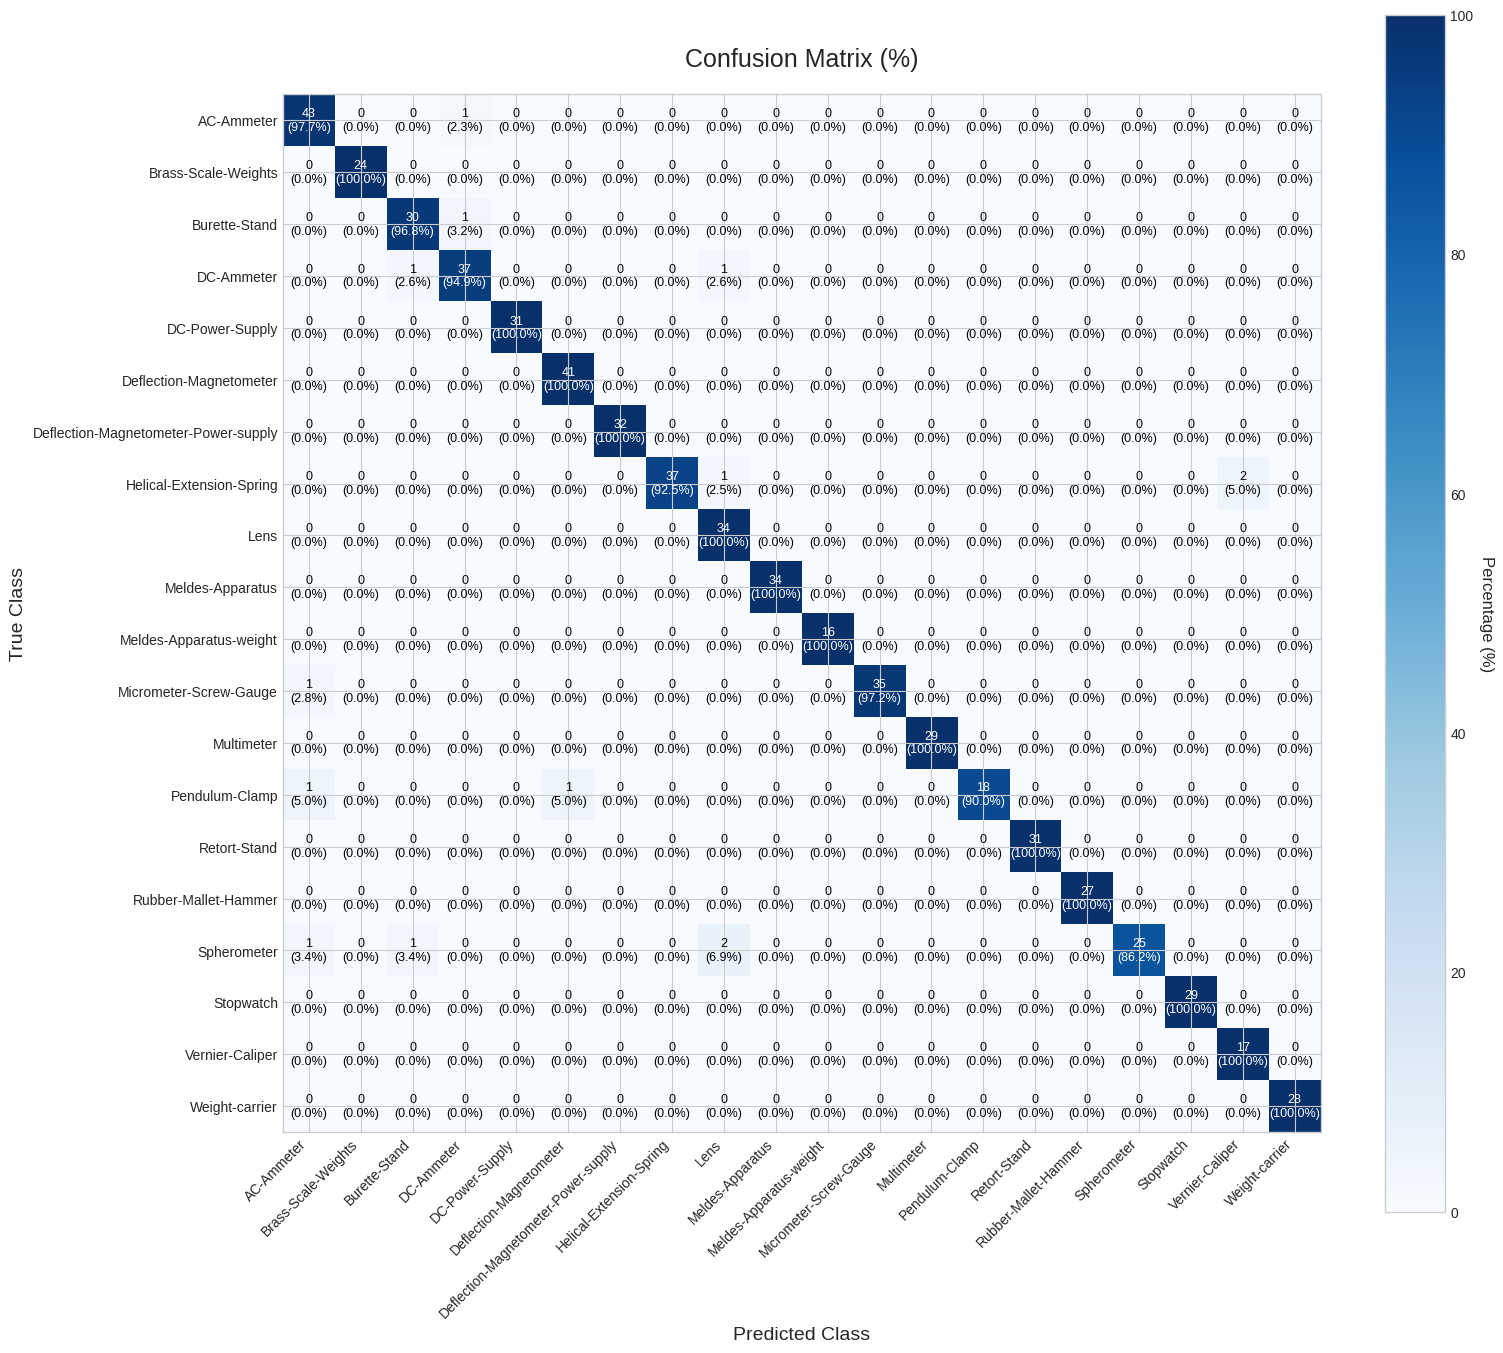

✅ Saved confusion matrix with class names: confusion_matrix_20_classes_with_names.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# ==== Folder for saving ====
save_folder = "/content/mobilenetv3_fig"
os.makedirs(save_folder, exist_ok=True)


import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# =========================
# 1. Run validation loop
# =========================
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.sigmoid(logits).cpu().numpy()        # probabilities
        preds = (preds > 0.5).astype(int)                 # threshold at 0.5
        all_preds.append(preds)
        all_targets.append(y.numpy())

# Stack all batches
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# =========================
# 2. Convert multi-label to top-1 single-label
# =========================
y_true_single = all_targets.argmax(axis=1)
y_pred_single = all_preds.argmax(axis=1)

# =========================
# 3. Compute confusion matrix
# =========================
num_classes = len(classes)   # use your actual class list
class_labels = classes       # class names from your dataset

cm = confusion_matrix(y_true_single, y_pred_single, labels=np.arange(num_classes))

# =========================
# 4. Normalize to percentages
# =========================
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# =========================
# 5. Plot high-quality annotated confusion matrix
# =========================
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16,14))  # larger figure for class names

# Plot the heatmap
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Percentage (%)", rotation=-90, va="bottom", fontsize=12)

# Show all ticks
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_labels, rotation=45, ha="right")
ax.set_yticklabels(class_labels)

# Title and labels
ax.set_title("Confusion Matrix (%)", fontsize=18, pad=20)
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)

# Annotate each cell with count and percentage
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i, j]
        percent = cm_percent[i, j]
        text = f"{count}\n({percent:.1f}%)"
        ax.text(j, i, text, ha="center", va="center", color="white" if percent > 50 else "black", fontsize=9)

plt.tight_layout()
plt.show()

# =========================
# Optional: save figure
# =========================
save_path = "confusion_matrix_20_classes_with_names.png"
plt.savefig(save_path, dpi=600, bbox_inches="tight")
print(f"✅ Saved confusion matrix with class names: {save_path}")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Folder to save plots
save_folder = "/content/plots"
os.makedirs(save_folder, exist_ok=True)

# Metrics with your scores
metrics = {
    "Macro AP": 0.9950,
    "Macro F1": 0.9807,
    "Micro F1": 0.9785,
    "Macro P": 0.9857,
    "Macro R": 0.9765
}

labels = list(metrics.keys())
values = list(metrics.values())
num_vars = len(labels)

# Angles for radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_ylim(0, 1.25)  # extra space for labels

# Plot radar line and fill
ax.plot(angles, values, color='blue', linewidth=2, linestyle='solid', marker='o', markersize=6)
ax.fill(angles, values, color='blue', alpha=0.25)

# Set category labels
# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Set y-axis ticks and labels
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"], fontsize=10)

# Cleaner y-axis (hide numbers)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([])

for i, (angle, value) in enumerate(zip(angles[:-1], values[:-1])):
    # Default offset
    x = angle
    y = value + 0.10  # Slightly smaller push for other labels

    # Special fix for the first label "Macro AP" (index 0)
    if i == 0:
        y = value + 0.03   # push less vertically
        x = angle + 0.10   # push slightly to the right

    # Alignment
    ha = 'left' if np.cos(angle) >= 0 else 'right'
    va = 'bottom' if np.sin(angle) >= 0 else 'top'

    ax.text(x, y, f"{value:.4f}", ha=ha, va=va,
            fontsize=11, fontweight='bold')

# Save figure
radar_path = os.path.join(save_folder, "metrics_radar2.png")
plt.savefig(radar_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Radar chart saved to: {radar_path}")


Radar chart saved to: /content/plots/metrics_radar2.png


In [ ]:
import os, torch, numpy as np, pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm

# ==== Dataset Setup ====
data_dir = Path("mlcls_dataset")

classes = [c.strip() for c in open(data_dir/"classes.txt")]
num_classes = len(classes)

train_df = pd.read_csv(data_dir/"train.csv")
valid_csv = data_dir/"valid.csv" if (data_dir/"valid.csv").exists() else data_dir/"val.csv"
val_df = pd.read_csv(valid_csv)

mlb = MultiLabelBinarizer(classes=classes)
train_labels = mlb.fit_transform(train_df["labels"].fillna("").str.split())
val_labels   = mlb.transform(val_df["labels"].fillna("").str.split())

tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class MLSet(Dataset):
    def __init__(self, df, Y):
        self.df, self.Y = df, Y
    def __getitem__(self, i):
        img = Image.open(self.df["filepath"].iloc[i]).convert("RGB")
        return tfm(img), torch.tensor(self.Y[i]).float()
    def __len__(self):
        return len(self.df)

train_loader = DataLoader(MLSet(train_df, train_labels), batch_size=32, shuffle=True)
val_loader   = DataLoader(MLSet(val_df, val_labels), batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ==== Model (ResNet50) ====
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# ==== Training Setup ====
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

best_val = float("inf")

# ==== Training Loop ====
for epoch in range(1, 51):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            val_loss += criterion(model(x), y).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch:02d}/50 | TrainLoss: {train_loss:.4f} | ValLoss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "classifier_resnet50.pt")

print("✅ Best model saved: classifier_resnet50.pt")

# ==== Evaluation Metrics ====
from sklearn.metrics import (
    precision_score, recall_score, f1_score, average_precision_score
)

model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Evaluating"):
        x = x.to(device)
        out = model(x)
        probs = torch.sigmoid(out).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_prob.append(probs)
        y_pred.append(preds)
        y_true.append(y.numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)
y_prob = np.vstack(y_prob)

macro_AP = average_precision_score(y_true, y_prob, average="macro")
macro_F1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
micro_F1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
macro_P  = precision_score(y_true, y_pred, average="macro", zero_division=0)
macro_R  = recall_score(y_true, y_pred, average="macro", zero_division=0)

print("\n==== Multi-Label Classifier Evaluation (ResNet50) ====")
print(f"macro AP: {macro_AP:.4f} | macro F1: {macro_F1:.4f} | micro F1: {micro_F1:.4f} | "
      f"macro P: {macro_P:.4f} | macro R: {macro_R:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Epoch 01/50 | TrainLoss: 0.0569 | ValLoss: 0.0504
Epoch 02/50 | TrainLoss: 0.0169 | ValLoss: 0.0364
Epoch 03/50 | TrainLoss: 0.0082 | ValLoss: 0.0271
Epoch 04/50 | TrainLoss: 0.0059 | ValLoss: 0.0275
Epoch 05/50 | TrainLoss: 0.0038 | ValLoss: 0.0232
Epoch 06/50 | TrainLoss: 0.0073 | ValLoss: 0.0275
Epoch 07/50 | TrainLoss: 0.0045 | ValLoss: 0.0179
Epoch 08/50 | TrainLoss: 0.0016 | ValLoss: 0.0163
Epoch 09/50 | TrainLoss: 0.0013 | ValLoss: 0.0225
Epoch 10/50 | TrainLoss: 0.0019 | ValLoss: 0.0455
Epoch 11/50 | TrainLoss: 0.0102 | ValLoss: 0.0556
Epoch 12/50 | TrainLoss: 0.0054 | ValLoss: 0.0202
Epoch 13/50 | TrainLoss: 0.0011 | ValLoss: 0.0231
Epoch 14/50 | TrainLoss: 0.0016 | ValLoss: 0.0276
Epoch 15/50 | TrainLoss: 0.0008 | ValLoss: 0.0204
Epoch 16/50 | TrainLoss: 0.0002 | ValLoss: 0.0207
Epoch 17/50 | TrainLoss: 0.0001 | ValLoss: 0.0187
Epoch 18/50 | TrainLoss: 0.0001 | ValLoss: 0.0192
Epoch 19/50 | TrainLoss: 0.0089 | ValLoss: 0.1209
Epoch 20/50 | TrainLoss: 0.0050 | ValLoss: 0.0214


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


==== Multi-Label Classifier Evaluation (ResNet50) ====
macro AP: 0.9892 | macro F1: 0.9630 | micro F1: 0.9626 | macro P: 0.9852 | macro R: 0.9437


In [ ]:
import os

# Folder path
save_folder = "/content/resnet50"
os.makedirs(save_folder, exist_ok=True)

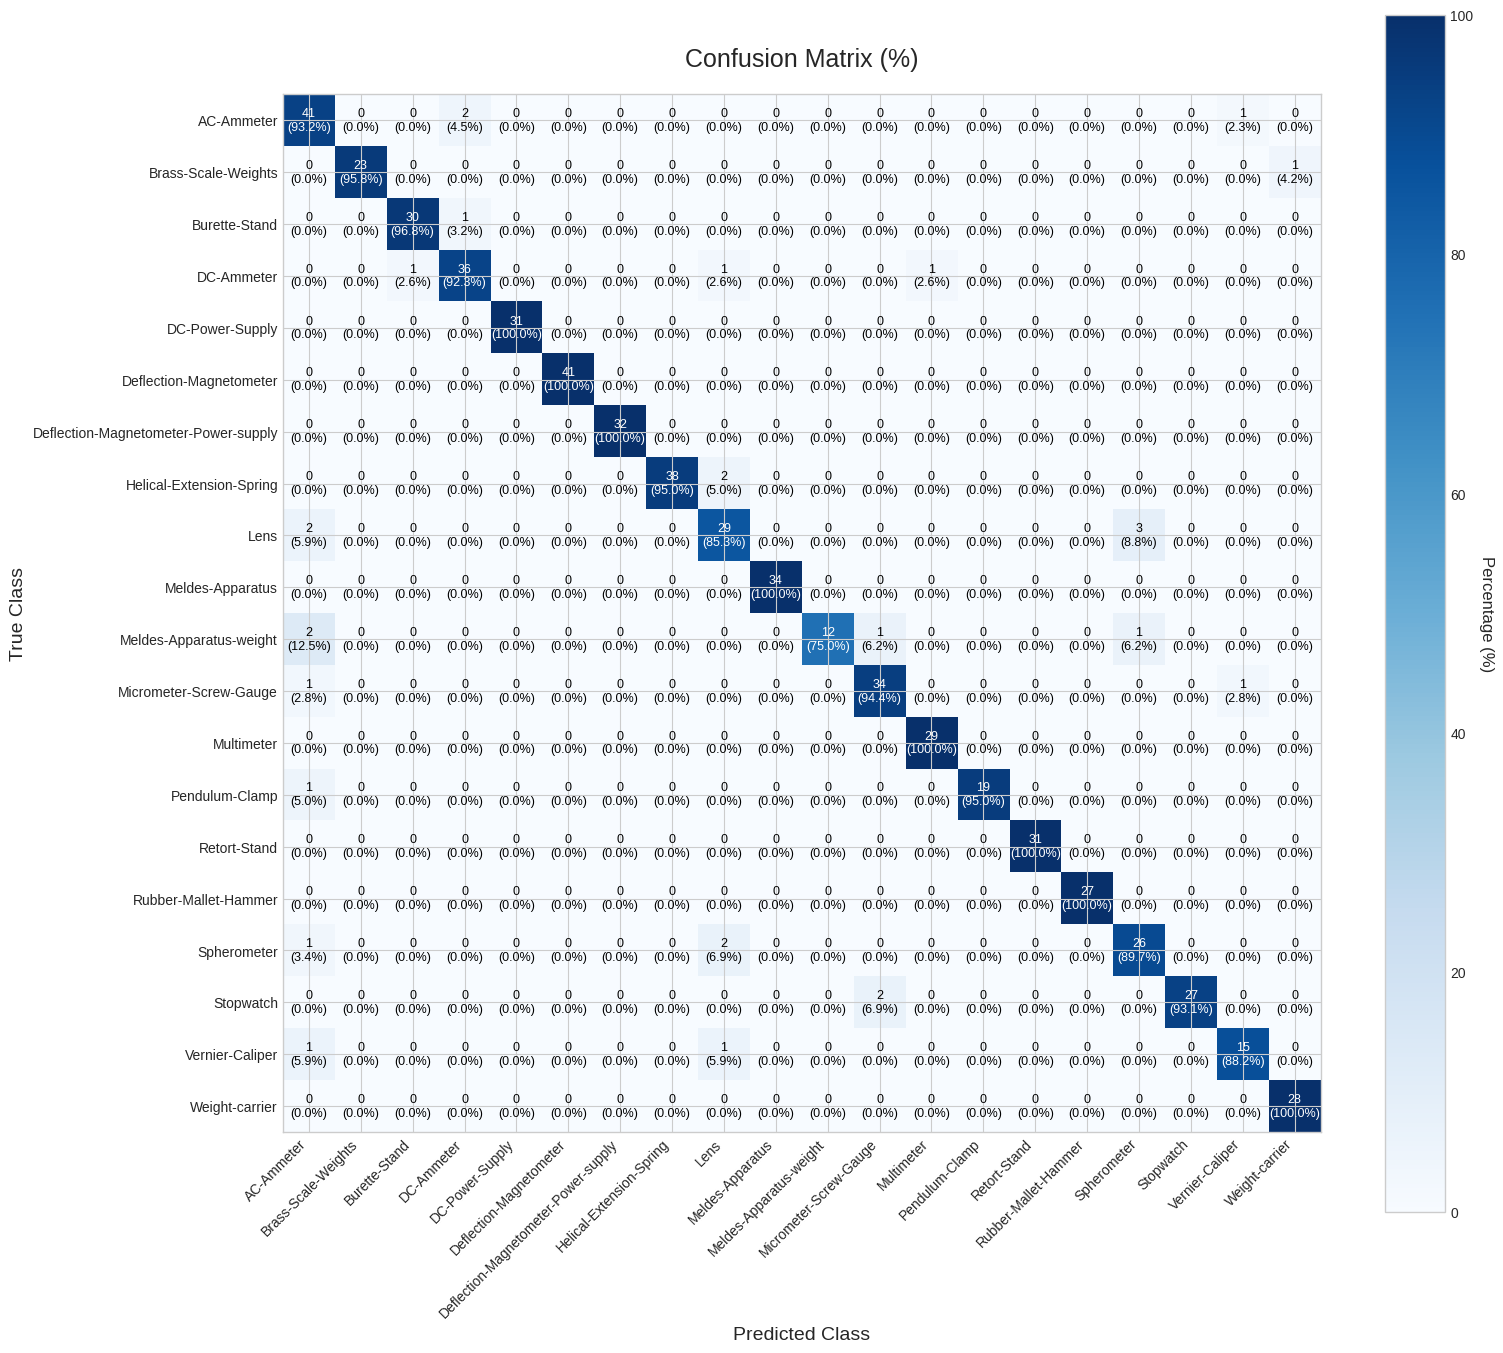

✅ Saved ResNet-50 confusion matrix with class names: /content/resnet50_fig/resnet50_confusion_matrix_with_class_names.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

# ==== Folder for saving ====
save_folder = "/content/resnet50_fig"
os.makedirs(save_folder, exist_ok=True)

# =========================
# 1. Run validation loop
# =========================
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()       # probabilities
        preds = (probs > 0.5).astype(int)                # threshold at 0.5
        all_preds.append(preds)
        all_targets.append(y.numpy())

# Stack all batches
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# =========================
# 2. Convert multi-label to top-1 single-label
# =========================
y_true_single = all_targets.argmax(axis=1)
y_pred_single = all_preds.argmax(axis=1)

# =========================
# 3. Compute confusion matrix
# =========================
num_classes = len(classes)   # your class list
class_labels = classes       # class names

cm = confusion_matrix(y_true_single, y_pred_single, labels=np.arange(num_classes))

# =========================
# 4. Normalize to percentages
# =========================
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# =========================
# 5. Plot high-quality annotated confusion matrix
# =========================
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16,14))

im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Percentage (%)", rotation=-90, va="bottom", fontsize=12)

# Tick marks and labels
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_labels, rotation=45, ha="right")
ax.set_yticklabels(class_labels)

# Labels and title
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)
ax.set_title("Confusion Matrix (%)", fontsize=18, pad=20)

# Annotate each cell with count and percentage
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i, j]
        percent = cm_percent[i, j]
        text_color = "white" if percent > 50 else "black"
        ax.text(j, i, f"{count}\n({percent:.1f}%)", ha="center", va="center", color=text_color, fontsize=9)

plt.tight_layout()

# =========================
# 6. Save figure
# =========================
save_path = os.path.join(save_folder, "resnet50_confusion_matrix_with_class_names.png")
plt.savefig(save_path, dpi=600, bbox_inches="tight")
plt.show()

print(f"✅ Saved ResNet-50 confusion matrix with class names: {save_path}")


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os

# ==== Folder to save plots ====
save_folder = "/content/resnet50_plots"
os.makedirs(save_folder, exist_ok=True)

# ==== Metrics for ResNet-50 ====
metrics = {
    "Macro AP":  0.9892,
    "Macro F1": 0.9626,
    "Micro F1": 0.9630,
    "Macro Precision": 0.9852,
    "Macro Recall": 0.9437
}

labels = list(metrics.keys())
values = list(metrics.values())
num_vars = len(labels)

# ==== Angles for radar chart ====
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values += values[:1]   # close the loop
angles += angles[:1]

# ==== Plot radar chart ====
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_ylim(0, 1.25)  # extra space for labels

# Radar line and fill
ax.plot(angles, values, color='blue', linewidth=2, linestyle='solid', marker='o', markersize=6)
ax.fill(angles, values, color='blue', alpha=0.25)

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Y-axis ticks (hide numbers)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([])

# Annotate values for each metric
for i, (angle, value) in enumerate(zip(angles[:-1], values[:-1])):
    x = angle
    y = value + 0.08  # offset for label

    # Fine-tune first label for better alignment
    if i == 0:
        y = value + 0.03
        x = angle + 0.05

    # Horizontal and vertical alignment
    ha = 'left' if np.cos(angle) >= 0 else 'right'
    va = 'bottom' if np.sin(angle) >= 0 else 'top'

    ax.text(x, y, f"{value:.4f}", ha=ha, va=va,
            fontsize=11, fontweight='bold')

# ==== Save figure ====
radar_path = os.path.join(save_folder, "resnet50_metrics_radar.png")
plt.savefig(radar_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ ResNet-50 radar chart saved to: {radar_path}")


✅ ResNet-50 radar chart saved to: /content/resnet50_plots/resnet50_metrics_radar.png


In [ ]:
import shutil
shutil.make_archive("/content", 'zip', "/content")
from google.colab import files
files.download("/content.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>